# 9기 과제 -  딥러닝 기반 이미지 검색 엔진 개발

## 과제 개요

 * 출제자 : 남상협(justin@buzzni.com) / 버즈니 (http://buzzni.com) 대표
 * 배경 : 최근 들어서 딥러닝 기술의 발달로 이미지 분류 성능이 크게 향상 되었다. 이미지 분류 성능의 경우에는 컴퓨터가 이미 사람보다 더 뛰어난 성능을 보여주고 있다. 이런 기술 발달에 힘입어서 이미지 인식 검색 기술 성능도 함께 향상되었고 여러 기업에서 관련 서비스를 내놓고 있다. 이미지 분류 성능은 사람보다 컴퓨터가 더 뛰어난 성능을 보여주지만, 이미지 인식 검색 기술은 아직 사람과 컴퓨터 간의 격차가 매우 큰 도전적인 기술 분야이다.  본 과제는 아직 향상 시킬 여지가 많고 사회에서도 활용가능성이 무궁무진한 이미지 인식 검색에 대해서 기본 코드를 제공하고, 이를 기반으로 해서 더 높은 성능을 내는 고도화된 엔진을 만드는 것을 목표로 한다. 
 * 활용 사례 : https://www.youtube.com/watch?v=-LsenqBcG8w
 


## 입력/출력
 * 용어 설명 
  * query 이미지 - 쇼핑몰 상품 상세에 판매자가 올린 상품 이미지 
  * compare 이미지 - 사용자가 직접 찍어서 올린 리뷰 이미지 (좀더 많은 노이즈 포함)
  
 * 입력 : query 이미지
 * 출력 : compare 이미지 중에서 query 이미지 상품과 가장 유사한 상품 TOP 10 (유사한 순서로 정렬)
 
## 목표  
 * 목표 : 다른 스타일의 이미지인 정제된 판매자 상품 이미지와, 노이즈가 많은 사용자 업로드 이미지 간에 같은 상품을 찾는 검색엔진을 만들게 된다.

## 평가 항목 
 * test160 mode 성능평가 (70%)
 * 제출문서 및 코드 (30%)
### 주의 사항
 * 외부 업체에서 제공해주는 API (Google Cloud Vision API 나 기타 유사한 API) 를 사용하는 경우 0점 
 * 다른 멘티의 코드를 카피한 경우 둘다 0점 
 * 비정상적인 방법으로 문제를 해결한 경우 0점 (예를 들어서 평가 데이터를 모두 눈으로 확인해서, 사람이 직접 정답 데이터를 만드는등.)
 * 제출한 문서 및 코드와, 제출한 성능평가가 다른 경우 0점 

## 제출 항목
 * name - 자신의 이름을 넣는다. 실제 점수판(leader board)에는 공개가 안됨, 추후 평가시에 일치하는 이름의 멘티 점수로 사용함. 요청한 평가 중에서 가장 높은 점수의 평가 점수로 업데이트됨.
 * nickname - 점수판에 공개되는 이름, 자신의 이름으로 해도 되고, 닉네임으로 해도 됨. (이상한 닉네임으로 할 경우 삭제)
 * pred_result - 아래에 나온 base 코드를 참고해서, 자신이 만든 모델로 각 query 별로 가장 유사한 TOP 10 개의 compare 이미지 리스트를 만든 값
 * mode - eval / test160, 파라미터 최적화를 할때에는 eval 사용 (횟수 제한 없음). 실제 평가에 사용하는 점수는 test160 모드 (한 ip 당 1일 1회 제한), 평가를 위해서 test160 mode 제출은 필수 
  * eval mode 예 
```python
name = '남상협'
nickname = 'justin'
email = 'justin@buzzni.com'
mode = 'eval'
r = requests.post('http://115.68.223.177:31000', json={"pred_result": system_result_dict,'name':name, 'nickname':nickname, 'mode':mode,'email':email})
print (r.json())
```
  * test160 mode 예 
```python
name = '남상협'
nickname = 'justin'
email = 'justin@buzzni.com'
mode = 'test160'
r = requests.post('http://115.68.223.177:31000', json={"pred_result": system_result_dict,'name':name, 'nickname':nickname, 'mode':mode,'email':email})
print (r.json())
```

## 리턴값 
 * ndcg 로 평가한 평가 점수, 1점 만점. 높을수록 좋은 점수
 
## 점수 확인판
 * http://eval.buzzni.net:31000/leader_board
 
 

## 성능 향상 포인트
 1. 예제로 제공한 Resnet18 보다 더 깊은 딥러닝 모델을 사용한다. 
 2. 예제로 제공한 딥러닝 모델보다 더 성능이 좋은 모델을 찾아서 사용한다.
 3. 예제에서는 fc layer 에 있는 값을 사용했는데, 이 이전에 있는 layer 값들을 활용한다.
 4. 이 이전에 있는 layer 값들을 더 잘 조합하는 방법을 스스로 생각하거나, 논문을 찾거나, 코드를 찾아서 적용해본다.
 5. object detection 방법을 활용한다.

In [2]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


In [3]:

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)




In [4]:
"""
ResNet code gently borrowed from
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""

from collections import OrderedDict
import math

import torch.nn as nn
from torch.utils import model_zoo

__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classfes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [5]:
res152 = se_resnet152(num_classes=1000, pretrained='imagenet')

In [6]:
from IPython.core.display import display
from IPython.core.display import Image as Image2
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
from PIL import Image
import requests

from io import BytesIO

### eval 모드 
 * 모델을 사용하기전에는 eval() 모드를 호출해줘야한다.

In [7]:
_ = res152.eval()

# _ = res152.train(False)

### 이미지 분류기 테스트 
 * 각 이미지별로 어떤 카테고리로 분류하는지 테스트한다.

In [8]:
trans = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # from http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
])
# 원래이미지를 크기 지정, Normailize는 크기 매핑

url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/' \
      'raw/596b27d23537e5a1b5751d2b0481ef172f58b539/imagenet1000_clsid_to_human.txt'

imagenet_classes = eval(requests.get(url).content)

images = [('cat', 'https://www.wired.com/wp-content/uploads/2015/02/catinbox_cally_by-helen-haden_4x31-660x495.jpg'),
          ('pomeranian', 'https://c.photoshelter.com/img-get/I0000q_DdkyvP6Xo/s/900/900/Pomeranian-Dog-with-Ball.jpg'),
          ('car', 'https://www.autocar.co.uk/sites/autocar.co.uk/files/styles/gallery_slide/public/images/car-reviews/first-drives/legacy/porsche-911_0.jpg')]
# images = [('shoes','http://thum.buzzni.com/unsafe/320x320/center/smart/http://172.16.10.6/maestro_img/query/query_21.jpg')]

for class_name, image_url in images:
    print(class_name)
    response = requests.get(image_url)
    im = Image.open(BytesIO(response.content))
    tens = Variable(trans(im))
    tens = tens.view(1, 3, 224, 224)
    preds = nn.LogSoftmax()(res152(tens)).data.cpu().numpy()
    res = np.argmax(preds)
    print('true (likely) label:', class_name)
    print('predicted', imagenet_classes[res], '\n')
    display(Image2(url=image_url,width=100))


cat
true (likely) label: cat
predicted carton 



/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


pomeranian
true (likely) label: pomeranian
predicted Pomeranian 



car
true (likely) label: car
predicted sports car, sport car 



In [9]:
from glob import glob
import io

## Eval 데이터에 대한 결과 전송 

### eval 데이터에 대해서 resnet18 모델을 사용해서 feature 를 추출한다.


In [10]:
EVAL_ROOT_DIR = '/app/workspace/data/eval/'

### query 이미지 확인

/app/workspace/data/eval//query/query_1.jpg


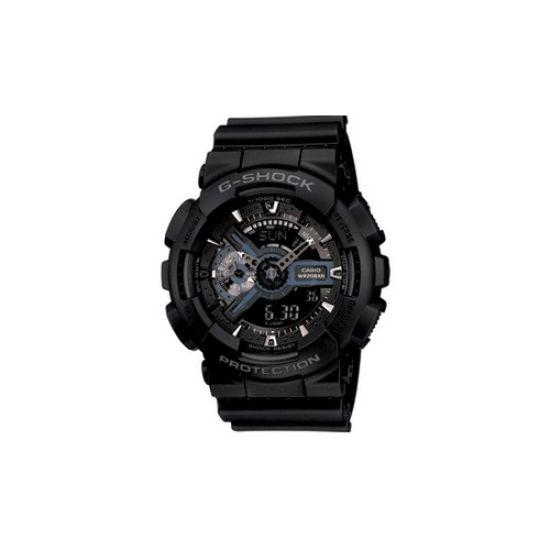

/app/workspace/data/eval//query/query_16.jpg


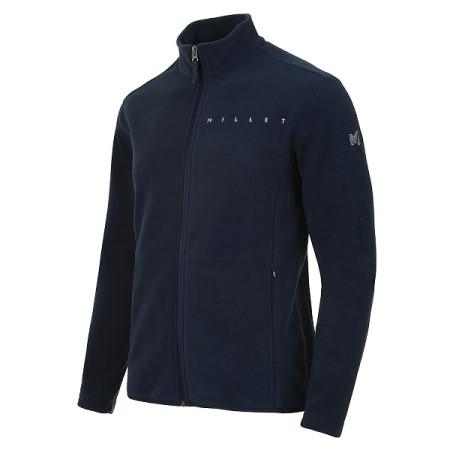

/app/workspace/data/eval//query/query_137.jpg


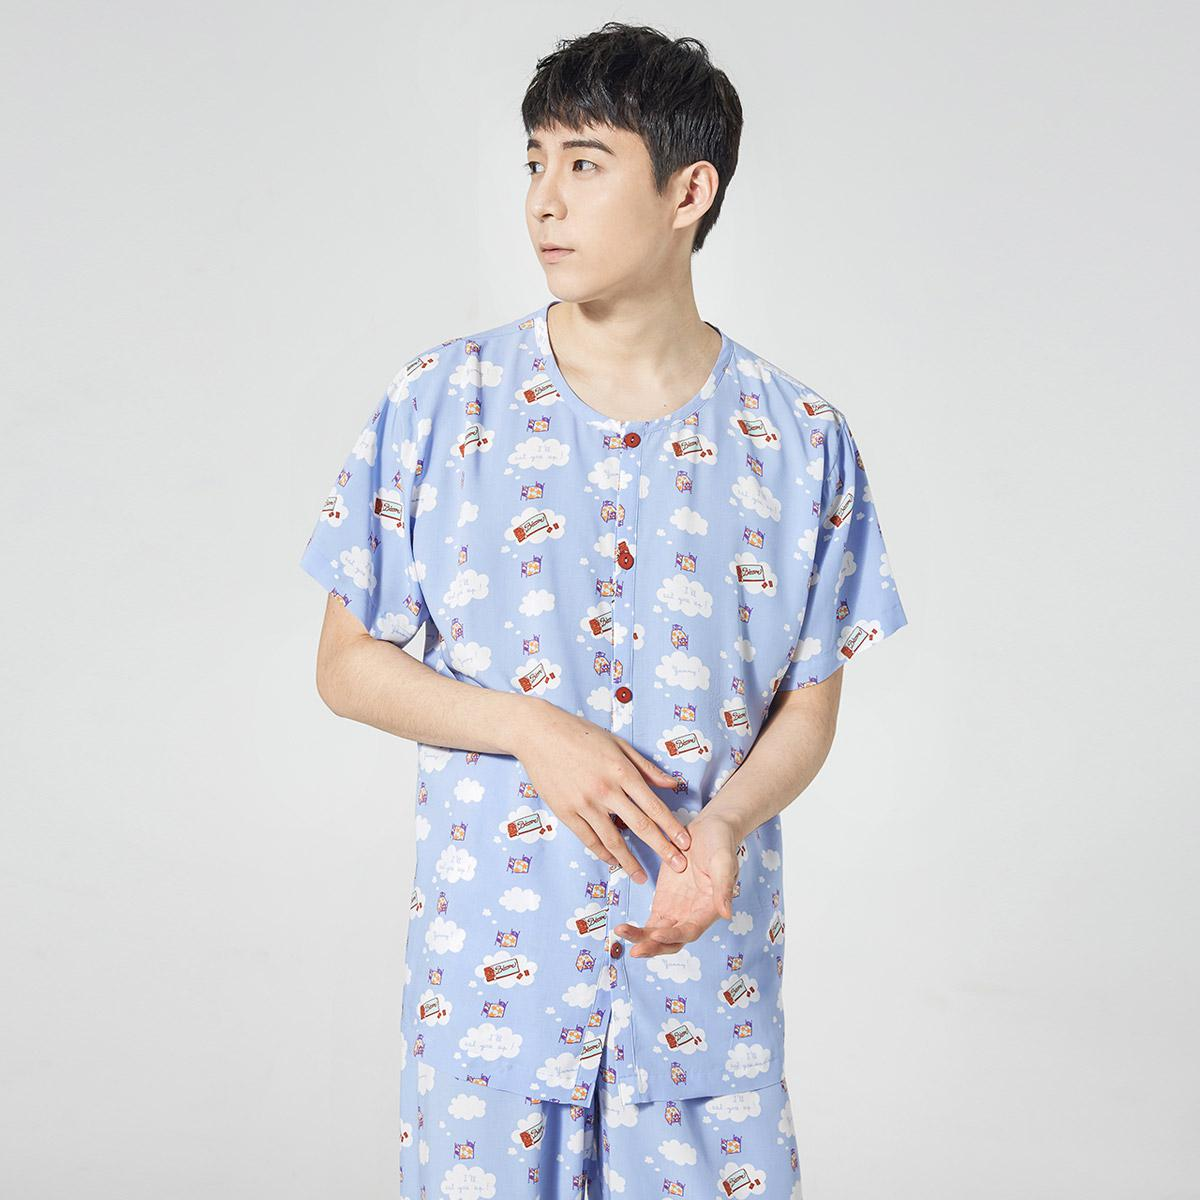

/app/workspace/data/eval//query/query_102.jpg


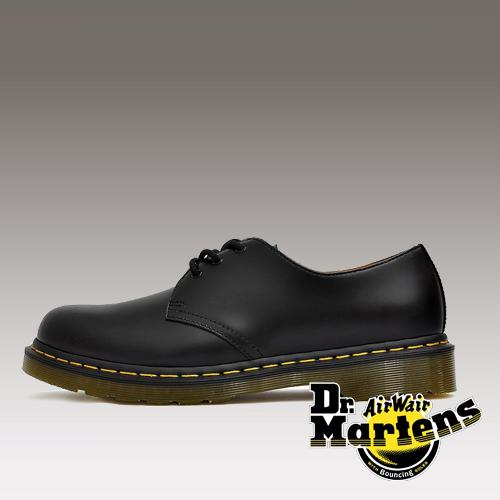

In [11]:
ct = 0
for each in glob(EVAL_ROOT_DIR + "/query/*"):
    print (each)
    display(Image2(filename=each,width=100))
    ct+=1
    if ct > 3:
        break

In [12]:
img_feature_dict = {}

In [13]:


for folder in ['compare','query']:
    idx = 0
    for each in glob(EVAL_ROOT_DIR + "/%s/*"%(folder)):        
        fname = each.split("/")[-1]
        if fname in img_feature_dict:
            continue
        try:
            idx +=1
            print(idx)
            byteImgIO = io.BytesIO()
            byteImg = Image.open(each)
            byteImg.save(byteImgIO, "PNG")
            byteImgIO.seek(0)
            byteImg = byteImgIO.read()
            dataBytesIO = io.BytesIO(byteImg)
            tens = Image.open(dataBytesIO)
            tens = Variable(trans(tens))
            tens = tens.view(1, 3, 224, 224)

            preds = nn.LogSoftmax()(res152(tens)).data.cpu().numpy()

            img_feature_dict[fname] = preds
        except Exception as e2:
            print(e2, fname)

1


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [14]:
import operator
from scipy.spatial.distance import cosine

### 추출된 image feature 를 활용해서 각 query 별로 가장 거리가 가까운 이미지들을 찾는다.

In [15]:
system_result_dict = {}
for each in glob(EVAL_ROOT_DIR + "/query/*"):
    
    fname = each.split("/")[-1]
    score_dict = {}
    print (each,fname)
    for other in glob(EVAL_ROOT_DIR + "/compare/*"):
        fname2 = other.split("/")[-1]
#         dist = cosine(res18_img_feature_dict[fname], res18_img_feature_dict[fname2])
        dist = cosine(img_feature_dict[fname], img_feature_dict[fname2])
#         print dist
        score_dict[fname2] = dist
#         break
    sorted_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=False)
    qid = fname.split("_")[-1].split(".")[0]
    system_result_dict[qid] = list(map(lambda i : i[0], sorted_list[:20]))


/app/workspace/data/eval//query/query_1.jpg query_1.jpg
/app/workspace/data/eval//query/query_16.jpg query_16.jpg
/app/workspace/data/eval//query/query_137.jpg query_137.jpg
/app/workspace/data/eval//query/query_102.jpg query_102.jpg
/app/workspace/data/eval//query/query_110.jpg query_110.jpg
/app/workspace/data/eval//query/query_97.jpg query_97.jpg
/app/workspace/data/eval//query/query_156.jpg query_156.jpg
/app/workspace/data/eval//query/query_152.jpg query_152.jpg
/app/workspace/data/eval//query/query_83.jpg query_83.jpg
/app/workspace/data/eval//query/query_72.jpg query_72.jpg
/app/workspace/data/eval//query/query_112.jpg query_112.jpg
/app/workspace/data/eval//query/query_91.jpg query_91.jpg
/app/workspace/data/eval//query/query_155.jpg query_155.jpg
/app/workspace/data/eval//query/query_98.jpg query_98.jpg
/app/workspace/data/eval//query/query_26.jpg query_26.jpg
/app/workspace/data/eval//query/query_124.jpg query_124.jpg
/app/workspace/data/eval//query/query_130.jpg query_130.jp

/app/workspace/data/eval//query/query_138.jpg query_138.jpg
/app/workspace/data/eval//query/query_82.jpg query_82.jpg
/app/workspace/data/eval//query/query_108.jpg query_108.jpg
/app/workspace/data/eval//query/query_5.jpg query_5.jpg
/app/workspace/data/eval//query/query_44.jpg query_44.jpg
/app/workspace/data/eval//query/query_70.jpg query_70.jpg
/app/workspace/data/eval//query/query_62.jpg query_62.jpg
/app/workspace/data/eval//query/query_24.jpg query_24.jpg
/app/workspace/data/eval//query/query_88.jpg query_88.jpg
/app/workspace/data/eval//query/query_19.jpg query_19.jpg
/app/workspace/data/eval//query/query_3.jpg query_3.jpg
/app/workspace/data/eval//query/query_58.jpg query_58.jpg
/app/workspace/data/eval//query/query_33.jpg query_33.jpg
/app/workspace/data/eval//query/query_10.jpg query_10.jpg
/app/workspace/data/eval//query/query_135.jpg query_135.jpg
/app/workspace/data/eval//query/query_38.jpg query_38.jpg
/app/workspace/data/eval//query/query_93.jpg query_93.jpg
/app/workspa

###  결과를 서버에 접수한다.
 * name : 자신의 이름을 작성한다.
 * nickname : leaderboard 에 올라갈 이름을 적는다. 
 * email : 자신의 이메일 
 * mode : eval 
 * 결과 확인 : http://eval.buzzni.net:31000/leader_board?mode=eval

In [16]:
name = 'cheonkyukim'
nickname = 'redtree941'
email = 'redtree941@naver.com'
mode = 'eval'
r = requests.post('http://115.68.223.177:31000', json={"pred_result": system_result_dict,'name':name, 'nickname':nickname, 'mode':mode,'email':email})
print (r.json())

{'score': 0.19533249132327107}


## Test160 데이터에 대한 결과 전송 (최종 평가)
 * 하루에 한 ip 당 1번만 전송 가능함.
 * 이전에 eval 을 통해서 충분히 최적화 한다음에 test 에 요청 

In [17]:
TEST_ROOT_DIR = '/app/workspace/data/test160/'

### query 이미지 확인

/app/workspace/data/test160//query/query_1.jpg


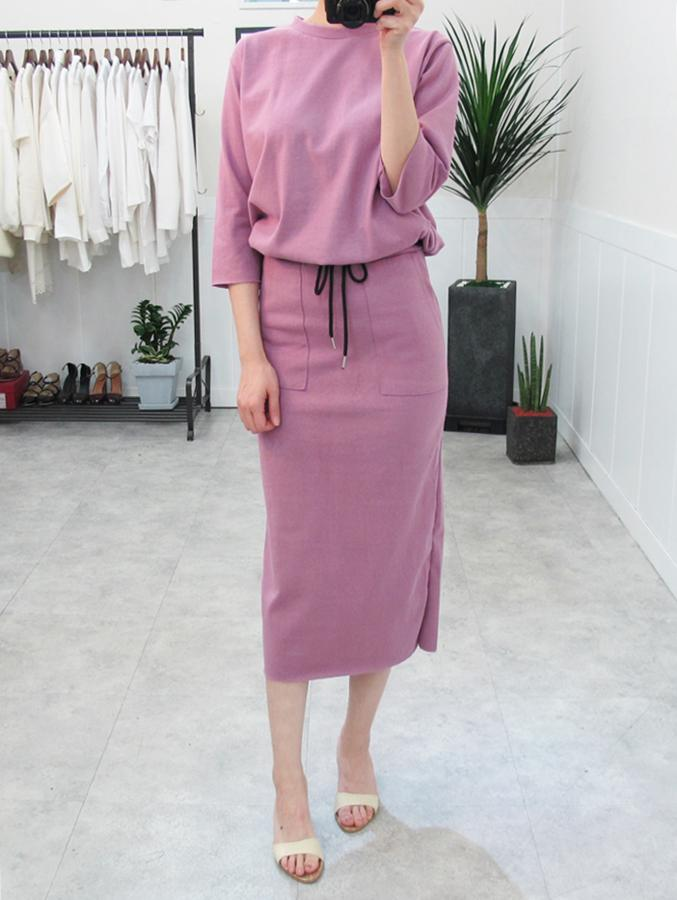

/app/workspace/data/test160//query/query_16.jpg


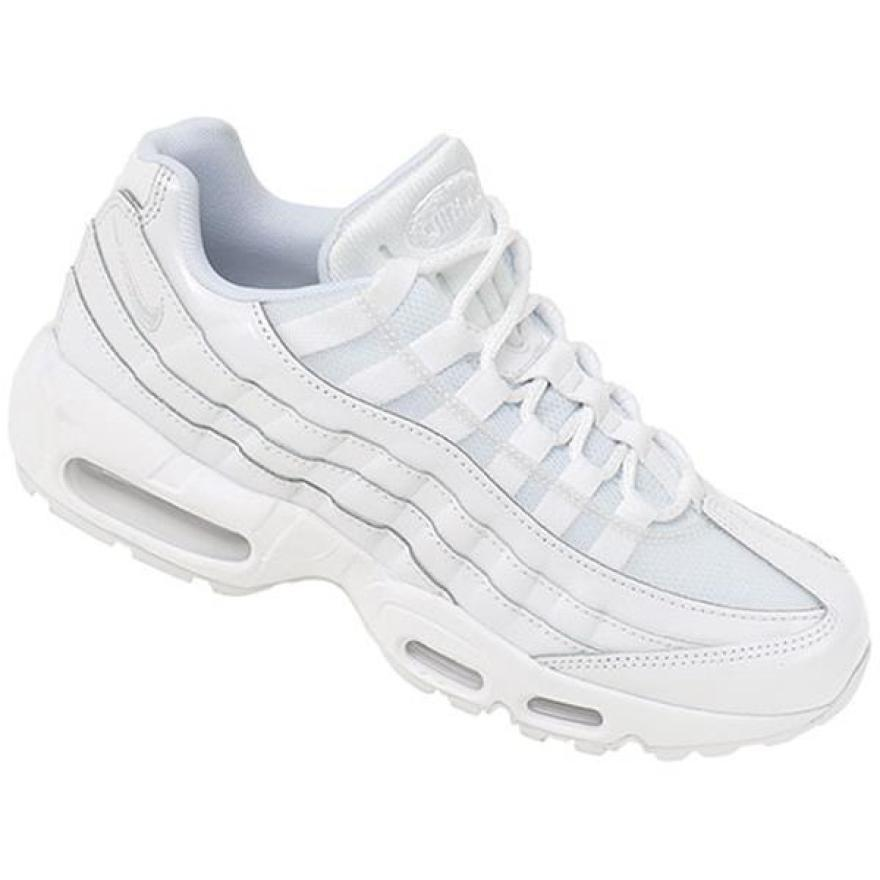

/app/workspace/data/test160//query/query_137.jpg


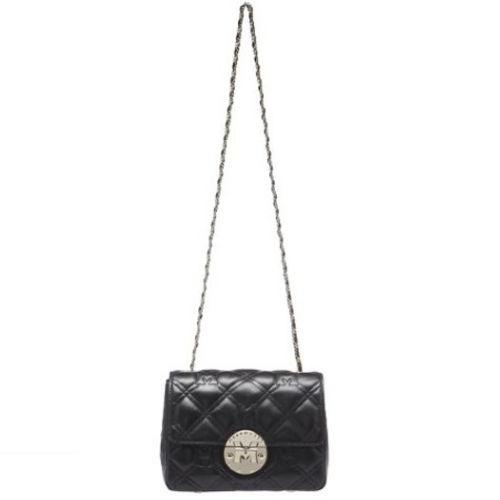

/app/workspace/data/test160//query/query_102.jpg


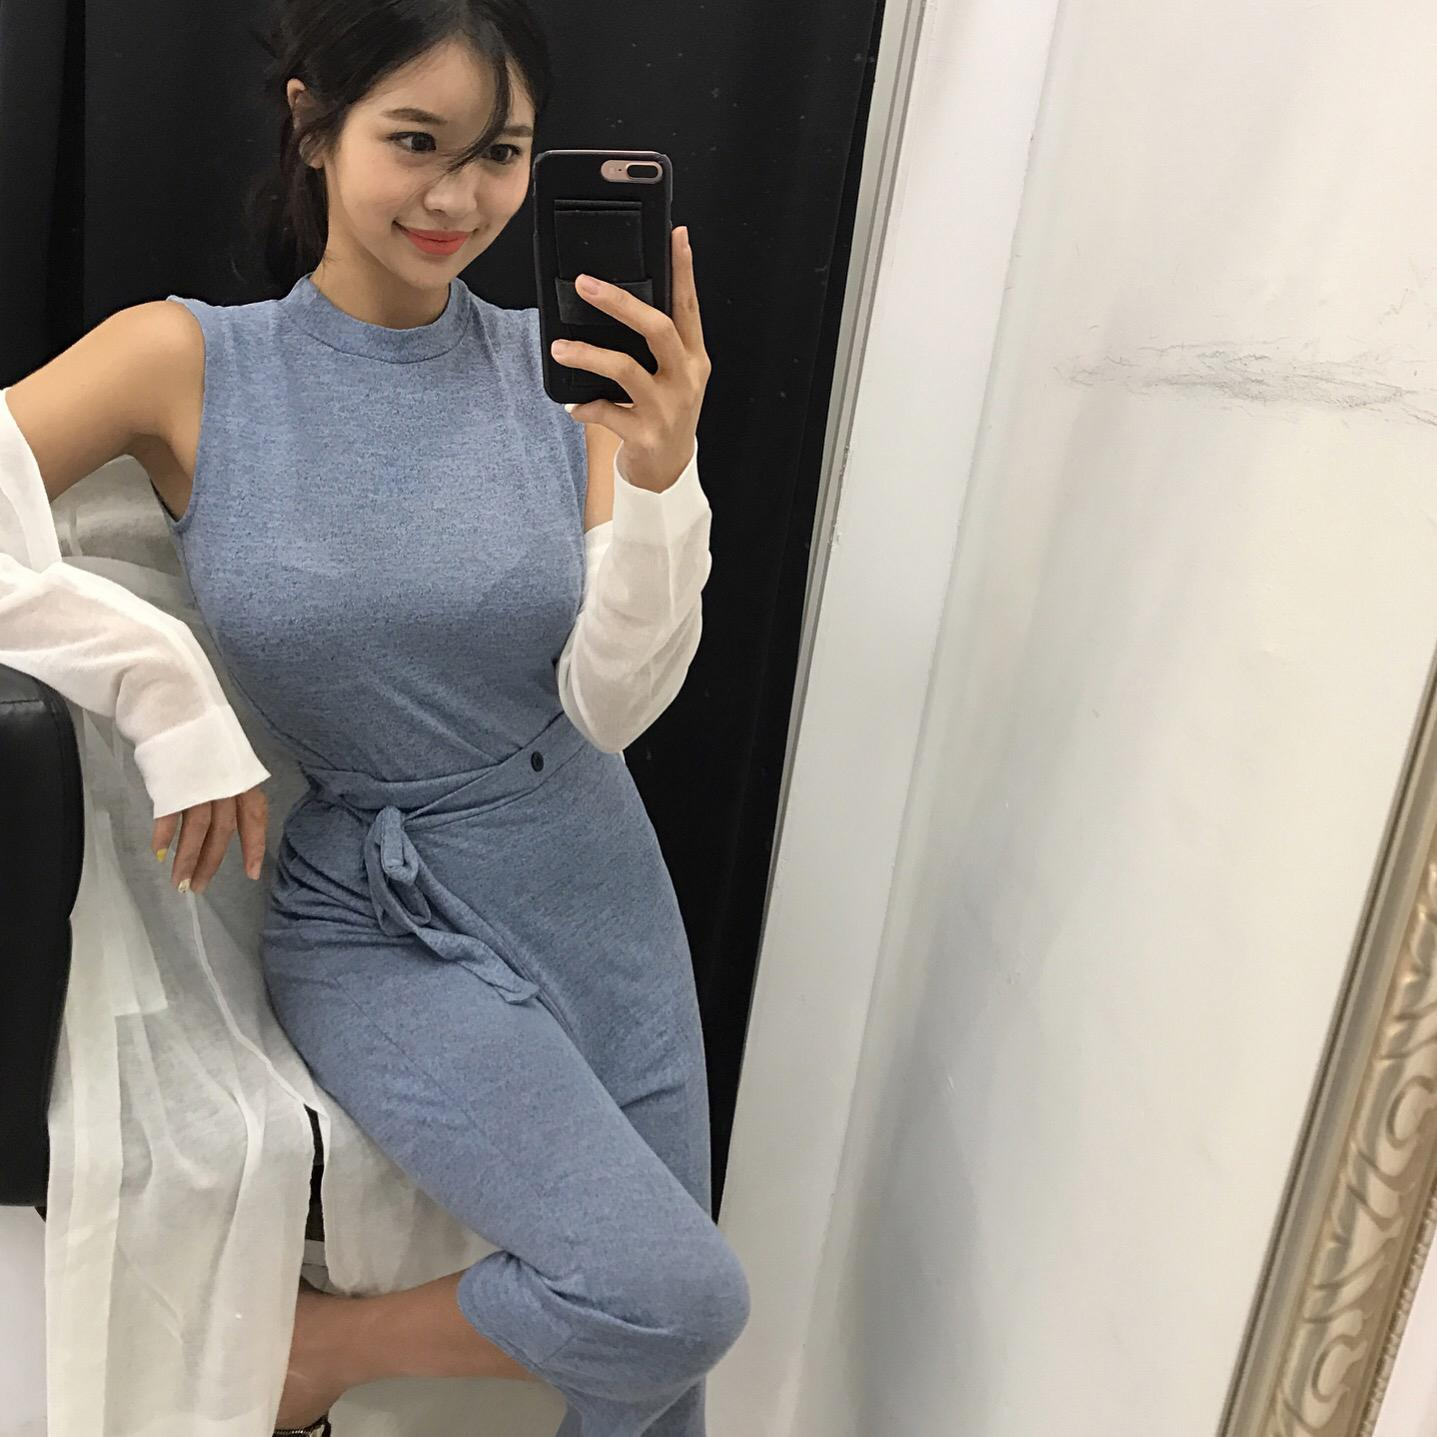

In [18]:
ct = 0
for each in glob(TEST_ROOT_DIR + "/query/*"):
    print (each)
    display(Image2(filename=each,width=100))
    ct+=1
    if ct > 3:
        break

In [19]:
img_feature_dict = {}

### Test160 데이터에 대해서 resnet18 모델을 사용해서 feature 를 추출한다.

In [20]:

for folder in ['compare','query']:
    idx = 0 
    for each in glob(TEST_ROOT_DIR + "/%s/*"%(folder)):        
        fname = each.split("/")[-1]
        idx +=1 
        if fname in img_feature_dict:
            continue
        try:
            
            print (idx)
            byteImgIO = io.BytesIO()
            byteImg = Image.open(each)
            byteImg.save(byteImgIO, "PNG")
            byteImgIO.seek(0)
            byteImg = byteImgIO.read()
            dataBytesIO = io.BytesIO(byteImg)
            tens = Image.open(dataBytesIO)
#             break
            tens = Variable(trans(tens))
            tens = tens.view(1, 3, 224, 224)

            preds = nn.LogSoftmax()(res152(tens)).data.cpu().numpy()

            img_feature_dict[fname] = preds
        except Exception as e2:
            print(e2, fname)

1


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

### 추출된 image feature 를 활용해서 각 query 별로 가장 거리가 가까운 이미지들을 찾는다.

In [21]:
system_result_dict = {}
idx = 0
for each in glob(TEST_ROOT_DIR + "/query/*"):    
    fname = each.split("/")[-1]
    score_dict = {}
    idx+=1
    print (idx, fname)    
    for other in glob(TEST_ROOT_DIR + "/compare/*"):
        fname2 = other.split("/")[-1]
        dist = cosine(img_feature_dict[fname], img_feature_dict[fname2])
        score_dict[fname2] = dist
    sorted_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=False)
    qid = fname.split("_")[-1].split(".")[0]
    system_result_dict[qid] = list(map(lambda i : i[0], sorted_list[:20]))



1 query_1.jpg
2 query_16.jpg
3 query_137.jpg
4 query_102.jpg
5 query_110.jpg
6 query_97.jpg
7 query_156.jpg
8 query_152.jpg
9 query_83.jpg
10 query_72.jpg
11 query_112.jpg
12 query_91.jpg
13 query_155.jpg
14 query_98.jpg
15 query_26.jpg
16 query_124.jpg
17 query_130.jpg
18 query_84.jpg
19 query_87.jpg
20 query_67.jpg
21 query_27.jpg
22 query_78.jpg
23 query_100.jpg
24 query_39.jpg
25 query_43.jpg
26 query_15.jpg
27 query_80.jpg
28 query_63.jpg
29 query_30.jpg
30 query_59.jpg
31 query_149.jpg
32 query_158.jpg
33 query_36.jpg
34 query_17.jpg
35 query_128.jpg
36 query_18.jpg
37 query_25.jpg
38 query_45.jpg
39 query_47.jpg
40 query_41.jpg
41 query_76.jpg
42 query_56.jpg
43 query_40.jpg
44 query_52.jpg
45 query_113.jpg
46 query_107.jpg
47 query_96.jpg
48 query_125.jpg
49 query_89.jpg
50 query_66.jpg
51 query_103.jpg
52 query_9.jpg
53 query_118.jpg
54 query_68.jpg
55 query_14.jpg
56 query_154.jpg
57 query_51.jpg
58 query_129.jpg
59 query_42.jpg
60 query_69.jpg
61 query_143.jpg
62 query_92.jp

###  결과를 서버에 접수한다.
 * name : 자신의 이름을 작성한다.
 * nickname : leaderboard 에 올라갈 이름을 적는다. 
 * email : 자신의 이메일 
 * mode : test160 
 * 결과 확인 : http://eval.buzzni.net:31000/leader_board?mode=test160

In [22]:
name = 'cheonkyu kim'
nickname = 'redtree941'
email = 'redtree941@naver.com'
mode = 'test160'
r = requests.post('http://115.68.223.177:31000', json={"pred_result": system_result_dict,'name':name, 'nickname':nickname, 'mode':mode,'email':email})
print (r.json())

{'score': 0.1996545384531076}
